<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>

# 深入监督学习：支持向量机

之前我们已经介绍了监督学习。有许多监督学习算法，这里我们介绍一种最强大且有意思的一种方法：**支持向量机（SVMs）**。

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# eliminate warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 支持向量机的动机

支持向量机（SVMs）是一种强大的监督学习算法，它可以用来进行分类和回归。SVMs是一种**判别式**分类器：用它可以在数据集之间划分边界。

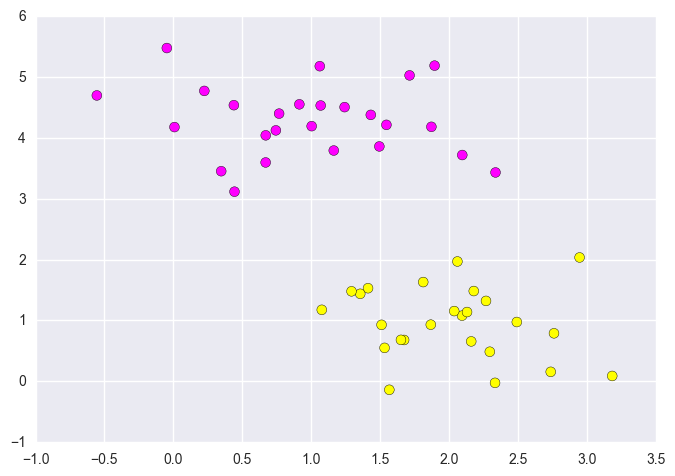

In [10]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

一个判别式分类器试图在两个不同的数据集之间画一条直线。但我们马上发现，这类直线是有问题的，我们可以画出好几条直线来完美区分这两类数据：

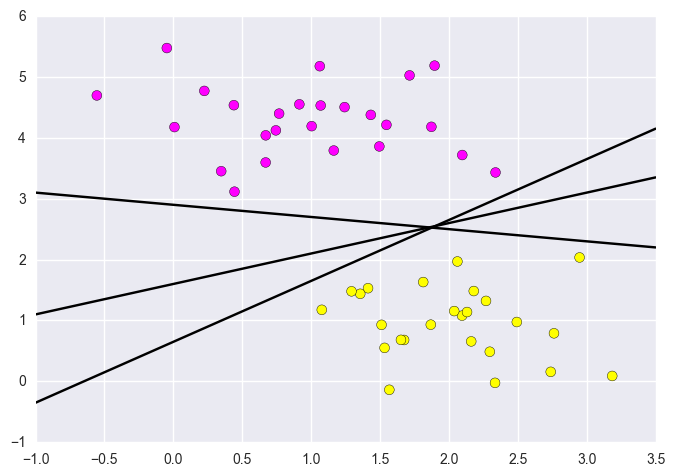

In [11]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

在这些样本中，我们有三种分割方式。到底采用哪种分割方式，才能适应新的数据，这个真的很纠结！

我们如何才能改进它呢？

### 支持向量机：最大化*Margin*

支持向量机可以解决这个问题。
支持向量机不仅仅画一条直线，还考虑了和这些直线相关的*region*，下面我们来看个例子。

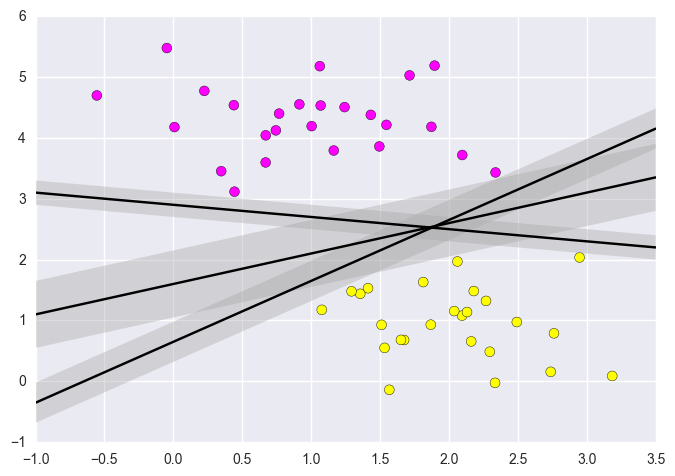

In [12]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

注意如果我们想最大化这个*region*，中间的直线貌似是最好的选择。
这是**支持向量机**直观表现，它通过数据集之间的**margin**来优化线性判别模型。

#### 拟合一个支持向量机

现在我们将对这些点拟合一个支持向量机分类器。尽管SVM模型的数学细节很有意思，但是这里不会涉及。我们把sklearn中SVM算法当做一个黑盒来完成上面的任务。

In [13]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

为了更好的可视化，我们写了一个函数来来绘制SVM决策边界：

In [57]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

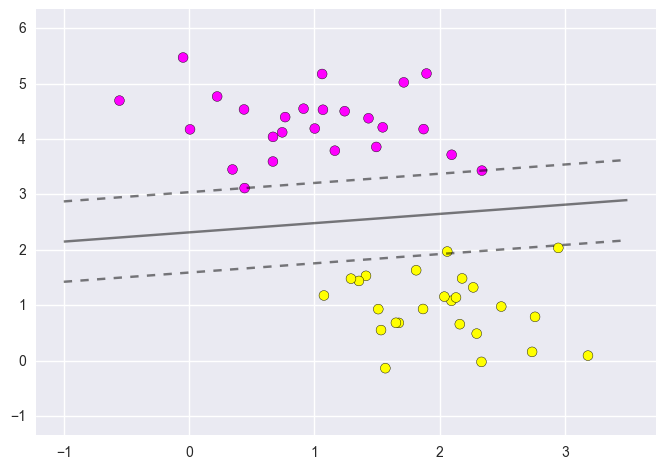

In [58]:
plt.scatter(X[:, 0].reshape(-1, 1), X[:, 1].reshape(-1, 1), c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

注意虚线上面有一对点落在上面，这些点是这次拟合的关键，被称为**支持向量**。在sklearn中，它们被存储在分类器的``support_vectors_``属性中。

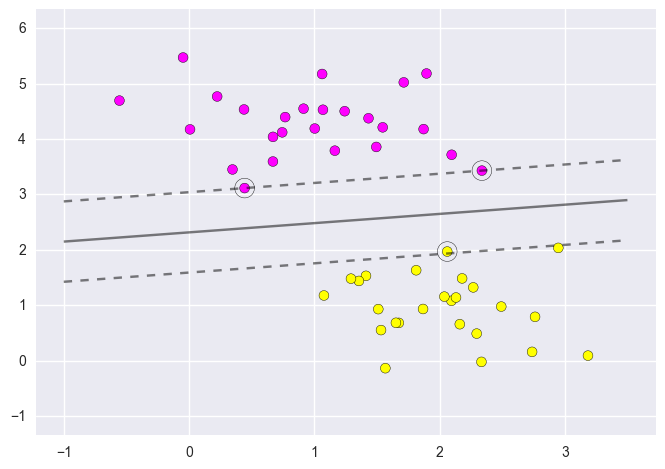

In [62]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

让我们用IPython的``interact``功能探索一下，点的分布是如何影响支持向量和判别拟合的。

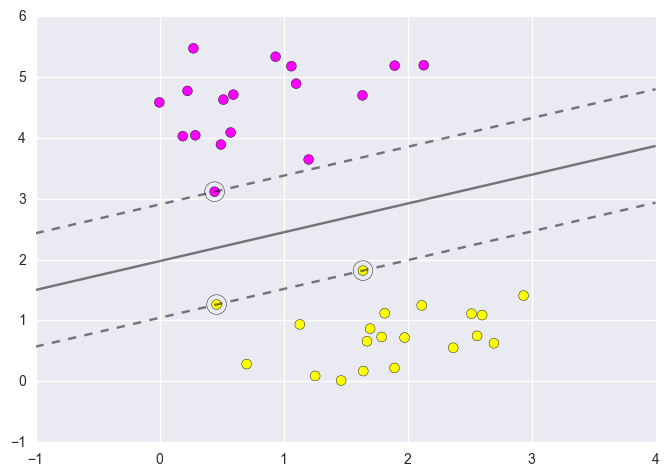

In [63]:
from IPython.html.widgets import interact

def plot_svm(N=10):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], kernel='linear');

注意如果你移动其他的任何点，如果它们没有越过决策边界，就不会对分类结果又影响。

#### 进一步看下Kernel方法

SVM还有一项很有用的特性叫做*kernels*。为了利用这个特性，我们看一些不能线性分割的数据：

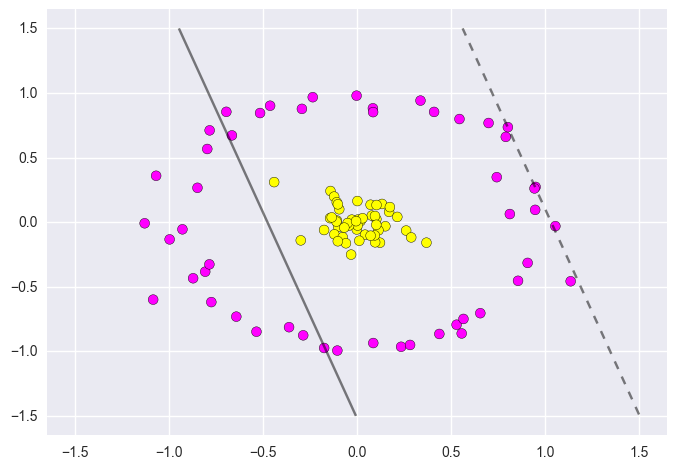

In [65]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

很明显，只有非线性的才能划分这些数据。一种方式是我们采用**kernel**，它能对输入数据做些变换。例如，我们能用的一个简单模型叫做**径向基函数核**

In [71]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

如果我们绘制出我们的数据，我们能看到它的效果。

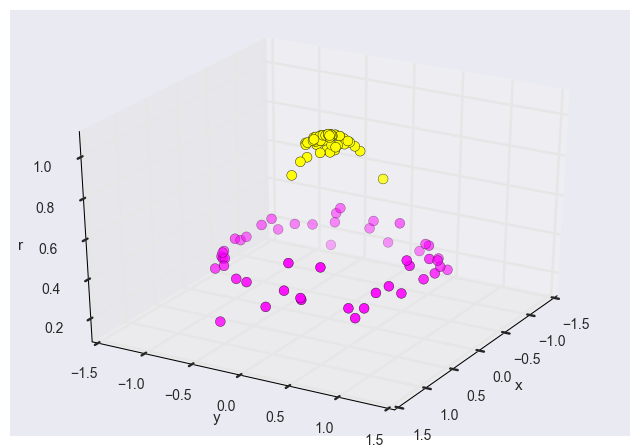

In [72]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

我们能看到加上了额外的维度，数据变得在很小范围可以线性可分。这是相对简单的核，SVM内置有一个更复杂核。我们能使用它通过设置``kernel='rbf'``，全称*径向基函数核*：

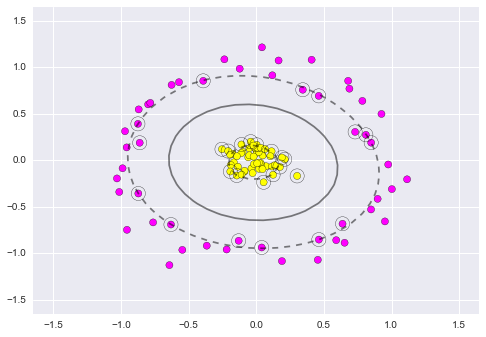

In [13]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');